In [31]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from flask import Flask, render_template, request
import pyspark
import findspark
findspark.init() 

In [ ]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [ ]:
wine = spark.read.csv('D:\\winemag.csv',
                      header='true', 
                      inferSchema='true', 
                      sep=',')

In [ ]:
wine.printSchema()

In [ ]:
wine.show(5)

In [ ]:
type(wine)

In [2]:
winedf = wine.toPandas()
winedf.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## Exploratory Data Analysis


In [3]:
winedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [4]:
winedf[winedf['description'].duplicated(keep = False)].sort_values('description').head(50)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
67614,67614,US,"100% Malbec, it's redolent with dark plums, wi...",NaN,87,20.0,Washington,Rattlesnake Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Roza Ridge 2010 Malbec (Rattlesnake Hills),Malbec,Roza Ridge
46540,46540,US,"100% Malbec, it's redolent with dark plums, wi...",NaN,87,20.0,Washington,Rattlesnake Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Roza Ridge 2010 Malbec (Rattlesnake Hills),Malbec,Roza Ridge
119702,119702,US,"100% Sangiovese, this pale pink wine has notes...",Meadow,88,18.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Ross Andrew 2013 Meadow Rosé (Columbia Valley ...,Rosé,Ross Andrew
72181,72181,US,"100% Sangiovese, this pale pink wine has notes...",Meadow,88,18.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Ross Andrew 2013 Meadow Rosé (Columbia Valley ...,Rosé,Ross Andrew
73731,73731,France,"87-89 Barrel sample. A pleasurable, perfumed w...",Barrel sample,88,NaN,Bordeaux,Saint-Julien,NaN,Roger Voss,@vossroger,Château Lalande-Borie 2008 Barrel sample (Sai...,Bordeaux-style Red Blend,Château Lalande-Borie
100745,100745,France,"87-89 Barrel sample. A pleasurable, perfumed w...",Barrel sample,88,NaN,Bordeaux,Saint-Julien,NaN,Roger Voss,@vossroger,Château Lalande-Borie 2008 Barrel sample (Sai...,Bordeaux-style Red Blend,Château Lalande-Borie
73730,73730,France,87-89 Barrel sample. Minty aromas give lifted ...,Barrel sample,88,NaN,Bordeaux,Saint-Émilion,NaN,Roger Voss,@vossroger,Château Haut-Sarpe 2008 Barrel sample (Saint-...,Bordeaux-style Red Blend,Château Haut-Sarpe
100744,100744,France,87-89 Barrel sample. Minty aromas give lifted ...,Barrel sample,88,NaN,Bordeaux,Saint-Émilion,NaN,Roger Voss,@vossroger,Château Haut-Sarpe 2008 Barrel sample (Saint-...,Bordeaux-style Red Blend,Château Haut-Sarpe
73729,73729,France,87-89 Barrel sample. With its lovely fresh fru...,Barrel sample,88,NaN,Bordeaux,Lalande de Pomerol,NaN,Roger Voss,@vossroger,Château Bertineau Saint-Vincent 2008 Barrel sa...,Bordeaux-style Red Blend,Château Bertineau Saint-Vincent
100743,100743,France,87-89 Barrel sample. With its lovely fresh fru...,Barrel sample,88,NaN,Bordeaux,Lalande de Pomerol,NaN,Roger Voss,@vossroger,Château Bertineau Saint-Vincent 2008 Barrel sa...,Bordeaux-style Red Blend,Château Bertineau Saint-Vincent


In [5]:
df = winedf.drop_duplicates('description')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119955 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             119955 non-null  int64  
 1   country                119896 non-null  object 
 2   description            119955 non-null  object 
 3   designation            85423 non-null   object 
 4   points                 119955 non-null  int64  
 5   price                  111567 non-null  float64
 6   province               119896 non-null  object 
 7   region_1               100397 non-null  object 
 8   region_2               46760 non-null   object 
 9   taster_name            95043 non-null   object 
 10  taster_twitter_handle  90514 non-null   object 
 11  title                  119955 non-null  object 
 12  variety                119954 non-null  object 
 13  winery                 119955 non-null  object 
dtypes: float64(1), int64(2), object(11)


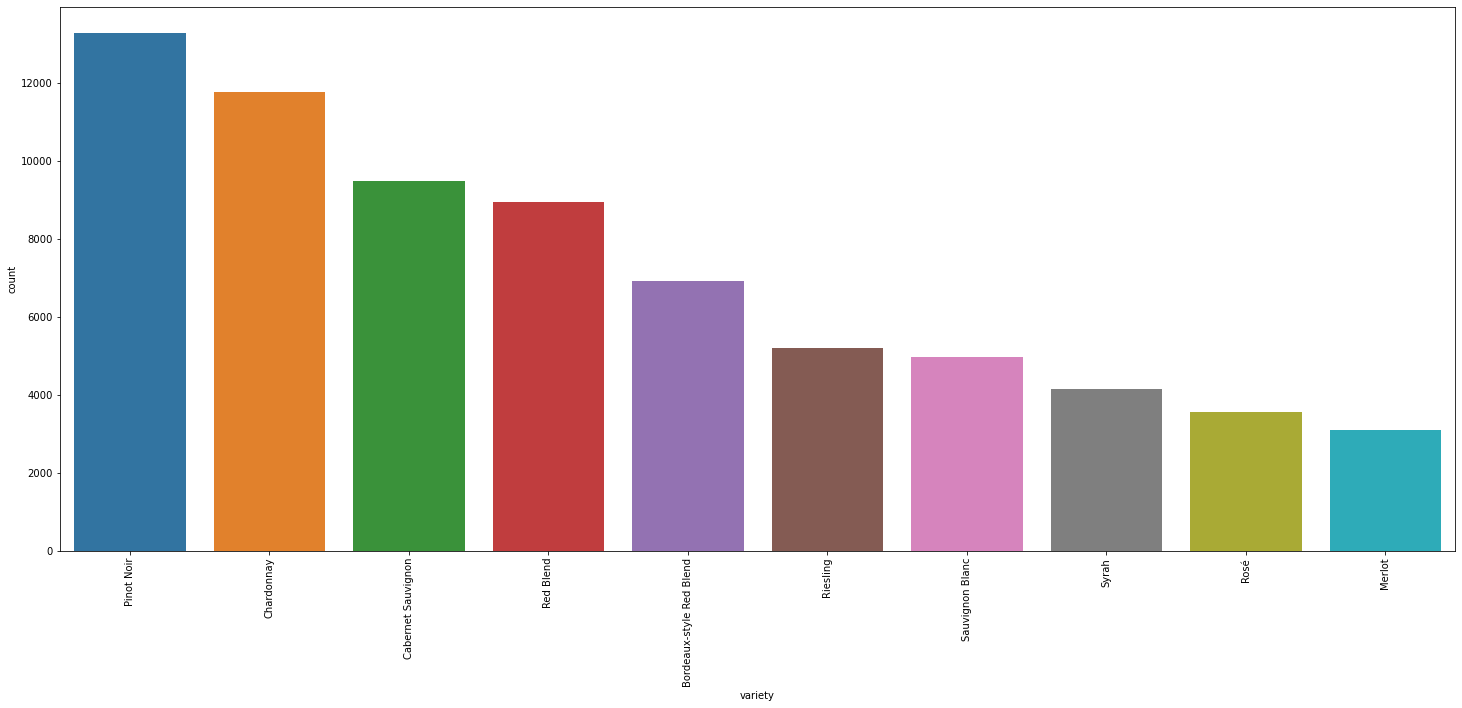

In [7]:
variety_df = winedf.groupby('variety').filter(lambda x: len(x) >3000)
varieties = variety_df['variety'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (25, 10))
sns.countplot(x = variety_df['variety'], order = varieties, ax = ax)
plt.xticks(rotation = 90)
plt.show()

In [8]:
variety_df

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
10,10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
12,12,US,"Slightly reduced, this wine offers a chalky, t...",NaN,87,34.0,California,Alexander Valley,Sonoma,Virginie Boone,@vboone,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini
14,14,US,Building on 150 years and six generations of w...,NaN,87,12.0,California,Central Coast,Central Coast,Matt Kettmann,@mattkettmann,Mirassou 2012 Chardonnay (Central Coast),Chardonnay,Mirassou
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129958,129958,New Zealand,This blend of Cabernet Sauvignon-Merlot and Ca...,Irongate,90,35.0,Hawke's Bay,NaN,NaN,Joe Czerwinski,@JoeCz,Babich 2010 Irongate Red (Hawke's Bay),Bordeaux-style Red Blend,Babich
129960,129960,Portugal,"Fresh and fruity, this is full of red cherry f...",Vértice,90,48.0,Douro,NaN,NaN,Roger Voss,@vossroger,Caves Transmontanas 2006 Vértice Pinot Noir (D...,Pinot Noir,Caves Transmontanas
129963,129963,Israel,"A bouquet of black cherry, tart cranberry and ...",Oak Aged,90,20.0,Galilee,NaN,NaN,Mike DeSimone,@worldwineguys,Dalton 2012 Oak Aged Cabernet Sauvignon (Galilee),Cabernet Sauvignon,Dalton
129966,129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)


In [9]:
variety_df['variety'].unique()

array(['Riesling', 'Pinot Noir', 'Cabernet Sauvignon', 'Chardonnay',
       'Red Blend', 'Merlot', 'Sauvignon Blanc',
       'Bordeaux-style Red Blend', 'Rosé', 'Syrah'], dtype=object)

## NLP

In [10]:
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
desc = variety_df['description'].values
vectorizer = TfidfVectorizer(stop_words = stop_words)
X = vectorizer.fit_transform(desc)

In [11]:
word_features = vectorizer.get_feature_names()
word_features[550:575]

['accentuate',
 'accentuated',
 'accentuates',
 'accentuating',
 'accept',
 'acceptability',
 'acceptable',
 'acceptance',
 'access',
 'accesses',
 'accessibile',
 'accessibility',
 'accessible',
 'accessibly',
 'accetnes',
 'accident',
 'accidental',
 'acciderba',
 'acclaimed',
 'accolade',
 'accolades',
 'accompained',
 'accompanied',
 'accompanies',
 'accompaniment']

In [12]:
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

In [13]:
vectorizer2 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize)
X2 = vectorizer2.fit_transform(desc)
word_features2 = vectorizer2.get_feature_names()
word_features2[:50]

D:\anaconda\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


["'s",
 "a'",
 "a'plenti",
 'aand',
 'aaron',
 'abacela',
 'abad',
 'abadia',
 'abandon',
 'abat',
 'abbey',
 'abbot',
 'abbott',
 'abbrevi',
 'abc',
 'abeill',
 'abeja',
 'abel',
 'abernathi',
 'aberr',
 'abetina',
 'abey',
 'abid',
 'abil',
 'abiou',
 'abl',
 'abli',
 'aboard',
 'abondant',
 'aborigin',
 'abound',
 'abouriou',
 'abov',
 'abras',
 'abreu',
 'abri',
 'abroad',
 'abrupt',
 'abruzzo',
 'absberg',
 'absenc',
 'absent',
 'absolut',
 'absorb',
 'abtsberg',
 'abund',
 'abus',
 'abut',
 'abuzz',
 'abv']

In [14]:
vectorizer3 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 1000)
X3 = vectorizer3.fit_transform(desc)
words = vectorizer3.get_feature_names()

In [15]:
words

['abound',
 'abov',
 'abund',
 'accent',
 'access',
 'accompani',
 'acid',
 'acr',
 'ad',
 'add',
 'addit',
 'afford',
 'aftertast',
 'age',
 'ageabl',
 'ager',
 'aggress',
 'air',
 'alcohol',
 'allow',
 'allspic',
 'almond',
 'alongsid',
 'alreadi',
 'alway',
 'american',
 'ampl',
 'ani',
 'anis',
 'anoth',
 'ap',
 'appeal',
 'appear',
 'appel',
 'appet',
 'appl',
 'approach',
 'apricot',
 'area',
 'aroma',
 'aromat',
 'array',
 'asian',
 'aspect',
 'asphalt',
 'assert',
 'astring',
 'atop',
 'attent',
 'attract',
 'auster',
 'away',
 'backbon',
 'backdrop',
 'background',
 'bacon',
 'bake',
 'balanc',
 'balsam',
 'banana',
 'bare',
 'barrel',
 'base',
 'basic',
 'bay',
 'bean',
 'beauti',
 'becaus',
 'becom',
 'beef',
 'befor',
 'begin',
 'bell',
 'benefit',
 'berri',
 'best',
 'better',
 'big',
 'bit',
 'bite',
 'bitter',
 'bittersweet',
 'black',
 'blackberri',
 'blanc',
 'blend',
 'block',
 'blossom',
 'blue',
 'blueberri',
 'boast',
 'bodi',
 'bold',
 'bone',
 'bordeaux',
 'bottl

## kMeans Clustering

In [16]:
kmeans = KMeans(n_clusters = 10, n_init = 5, n_jobs = -1)
kmeans.fit(X3)

D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


KMeans(n_clusters=10, n_init=5, n_jobs=-1)

In [17]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : chardonnay, pineappl, butter, flavor, toast, oak, vanilla, tropic, acid, rich
1 : pinot, noir, cherri, raspberri, silki, cola, flavor, acid, drink, dri
2 : wine, fruit, age, structur, tannin, wood, ripe, rich, drink, firm
3 : blackberri, flavor, currant, cherri, tannin, oak, wine, dri, rich, cabernet
4 : cabernet, sauvignon, blend, merlot, franc, petit, verdot, malbec, black, cherri
5 : black, cherri, palat, aroma, pepper, tannin, plum, spice, offer, alongsid
6 : lemon, lime, riesl, dri, finish, palat, peach, acid, miner, flavor
7 : wine, fruiti, acid, drink, crisp, fruit, attract, readi, light, textur
8 : flavor, fruit, wine, finish, cherri, aroma, berri, red, palat, note
9 : appl, citrus, flavor, finish, green, aroma, pear, palat, wine, fresh


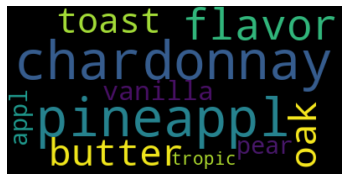

In [18]:
from wordcloud import WordCloud
text=['chardonnay', 'pineappl', 'flavor', 'butter', 'oak', 'toast', 'vanilla', 'pear', 'appl', 'tropic']
strt=','.join(text)
wordcloud = WordCloud().generate(strt)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [19]:
variety_df['cluster'] = kmeans.labels_

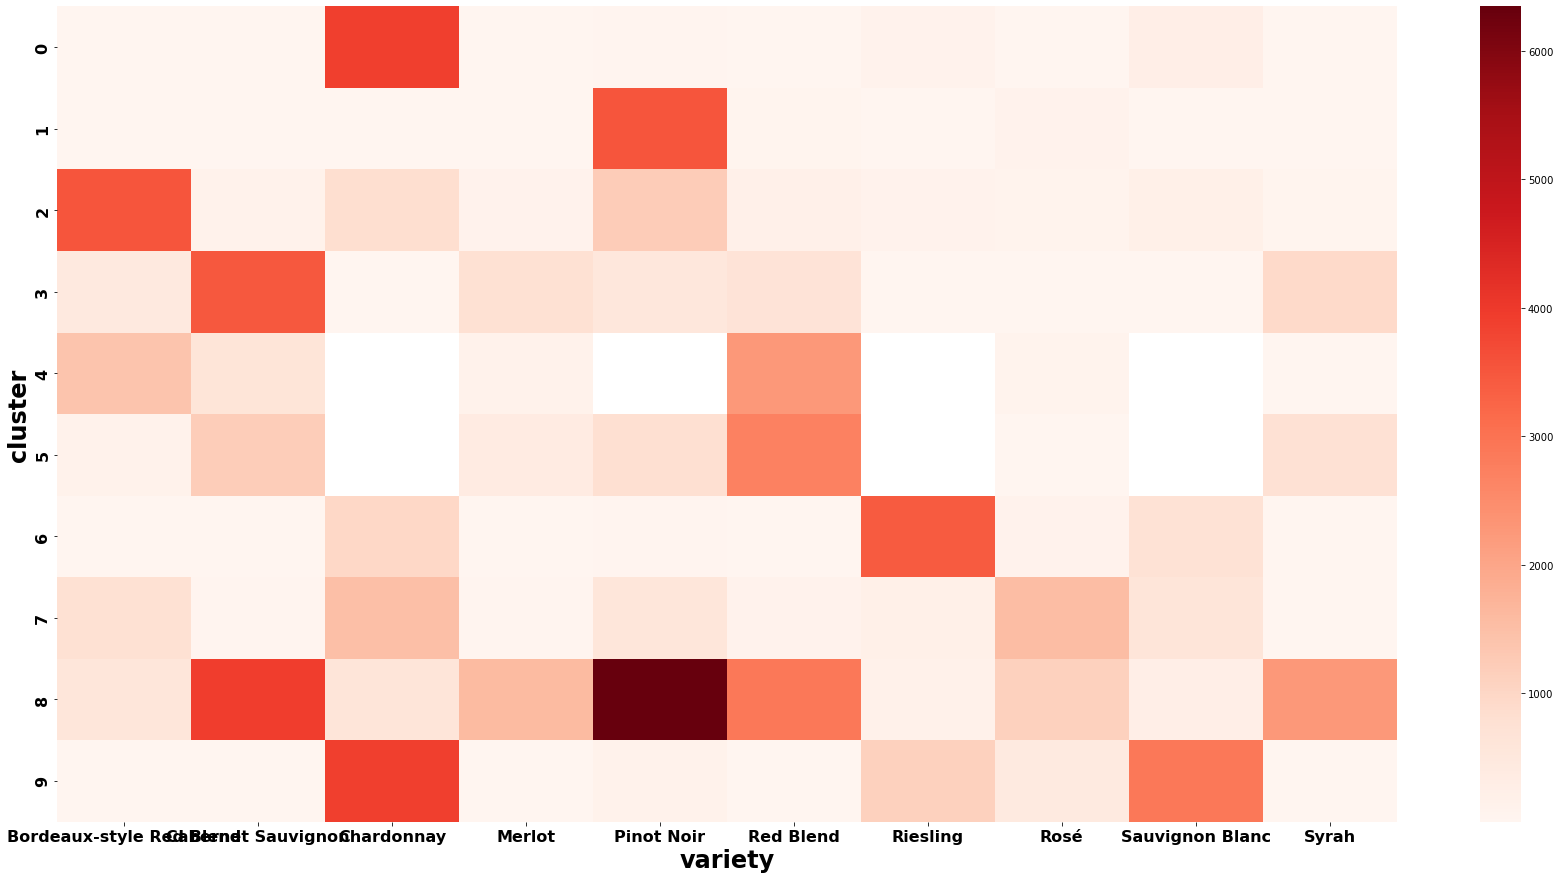

In [20]:
clusters = variety_df.groupby(['cluster', 'variety']).size()
fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'variety'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('variety', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

In [21]:
df=variety_df.copy()

In [22]:
df.dropna()
df.drop(columns = ['Unnamed: 0','country',
                   'points','price',
                   'region_2','taster_name','taster_twitter_handle','title'],axis=1,inplace = True) #remove useless cols

In [23]:
df.replace("nan",np.nan,inplace=True)
df=df.dropna()
df['cluster']=df['cluster'].apply(str)

In [24]:
df.loc[(df['winery']=='Three Sticks')]

,description,designation,province,region_1,variety,winery,cluster
4521,This is a beautiful display of Durell's greatn...,Durell Vineyard Origin,California,Sonoma Valley,Chardonnay,Three Sticks,9
8882,Site speaks loudly in this beautifully made wi...,Durell Vineyard,California,Sonoma Coast,Pinot Noir,Three Sticks,2
14612,This producer owns the coveted vineyard design...,Gap's Crown Vineyard,California,Sonoma Coast,Pinot Noir,Three Sticks,8
15516,"Round and rich, this wine takes on renewed com...",Durell Vineyard,California,Sonoma Coast,Pinot Noir,Three Sticks,8
20369,"This is possibly the richest, ripest unoaked C...",Durell Vineyard Origin,California,Sonoma Valley,Chardonnay,Three Sticks,0
22505,The grapes for this beautiful wine come from a...,One Sky,California,Sonoma Mountain,Chardonnay,Three Sticks,0
23675,"This vineyard blend shows the riper, oakier si...",The James,California,Sta. Rita Hills,Pinot Noir,Three Sticks,1
24502,The second vintage by this producer from this ...,Gap's Crown Vineyard,California,Sonoma Coast,Pinot Noir,Three Sticks,8
24769,"Aged for a year in stainless-steel barrels, th...",Durell Vineyard Origin,California,Sonoma Valley,Chardonnay,Three Sticks,9
28235,Consistency of richness and caramel toastiness...,Durell Vineyard,California,Sonoma Valley,Chardonnay,Three Sticks,8


In [ ]:
df.to_csv('data.csv',index=False)